# **Rawnet: Advanced end-to-end deep neural network using raw waveforms for text-independent speaker verification**

Jung, J. W., Heo, H. S., Kim, J. H., Shim, H. J., & Yu, H. J. (2019). Rawnet: Advanced end-to-end deep neural network using raw waveforms for text-independent speaker verification. arXiv preprint arXiv:1904.08104.

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

## **Build RawNet**

Not mentioned in the paper, so the two parts are ambiguous. These parts are filled in the direction I think is right.

```
## Fisrt (in residual_block()) - 1x1 conv or not
if residual.shape[-1] < filters:
    residual = Conv1D_BN_LeakyReLU(residual, filters, kernel_size = 1, use_activation = False)

## Second (in RawNet()) - relu or not
x = tf.keras.layers.Dense(128, activation = "relu")(x)
```

In [132]:
def Conv1D_BN_LeakyReLU(
    x, 
    filters, 
    kernel_size = 3, 
    strides = 1,
    padding = "same",
    kernel_regularizer = tf.keras.regularizers.L2(1e-4),
    use_activation = True
):
    x = tf.keras.layers.Conv1D(
        filters, 
        kernel_size, 
        strides = strides, 
        padding = padding,
        kernel_regularizer = kernel_regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if use_activation:
        x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)

    return x


def residual_block(
    x,
    filters,
):
    residual = x

    x = Conv1D_BN_LeakyReLU(x, filters)
    x = Conv1D_BN_LeakyReLU(x, filters, use_activation = False)

    ## When the input and output are the same dimensions, the shortcut performs identity mapping.
    ## When the demensions increase, the projection shortcut in Eqn.(2) is used to match dimensions (done by 1x1 conv).
    if residual.shape[-1] < filters:
        residual = Conv1D_BN_LeakyReLU(residual, filters, kernel_size = 1, use_activation = False)

    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.MaxPool1D(3, padding = "same")(x)

    return x

In [133]:
NUM_SPEAKERS = 1_211
INPUT_SIZE = [59_049, 1]

def RawNet(
    model_name = "RawNet",
):
    """RawNet v1.0 built in tensorflow"""

    model_input = tf.keras.layers.Input(shape = INPUT_SIZE, dtype = tf.dtypes.float32)
    
    ## Entry flow - stem.
    x = Conv1D_BN_LeakyReLU(model_input, 128, strides = 3)

    ## Middle flow - conv.
    for filters in [128] * 2 + [256] * 4:
        x = residual_block(x, filters)

    ## Middle flow - gru.
    x = tf.keras.layers.GRU(1024)(x)

    ## Exit flow.
    x = tf.keras.layers.Dense(128, activation = "relu")(x) ## not sure if relu is used or not
    x = tf.keras.layers.Dense(NUM_SPEAKERS)(x)

    model_output = tf.keras.layers.Activation(tf.nn.softmax)(x)

    return tf.keras.Model(
        inputs = model_input,
        outputs = x,
        name = model_name)

In [137]:
tmp = RawNet()
tmp.summary()

Model: "RawNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 59049, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_238 (Conv1D)             (None, 19683, 128)   512         input_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_238 (BatchN (None, 19683, 128)   512         conv1d_238[0][0]                 
__________________________________________________________________________________________________
activation_121 (Activation)     (None, 19683, 128)   0           batch_normalization_238[0][0]    
_____________________________________________________________________________________________

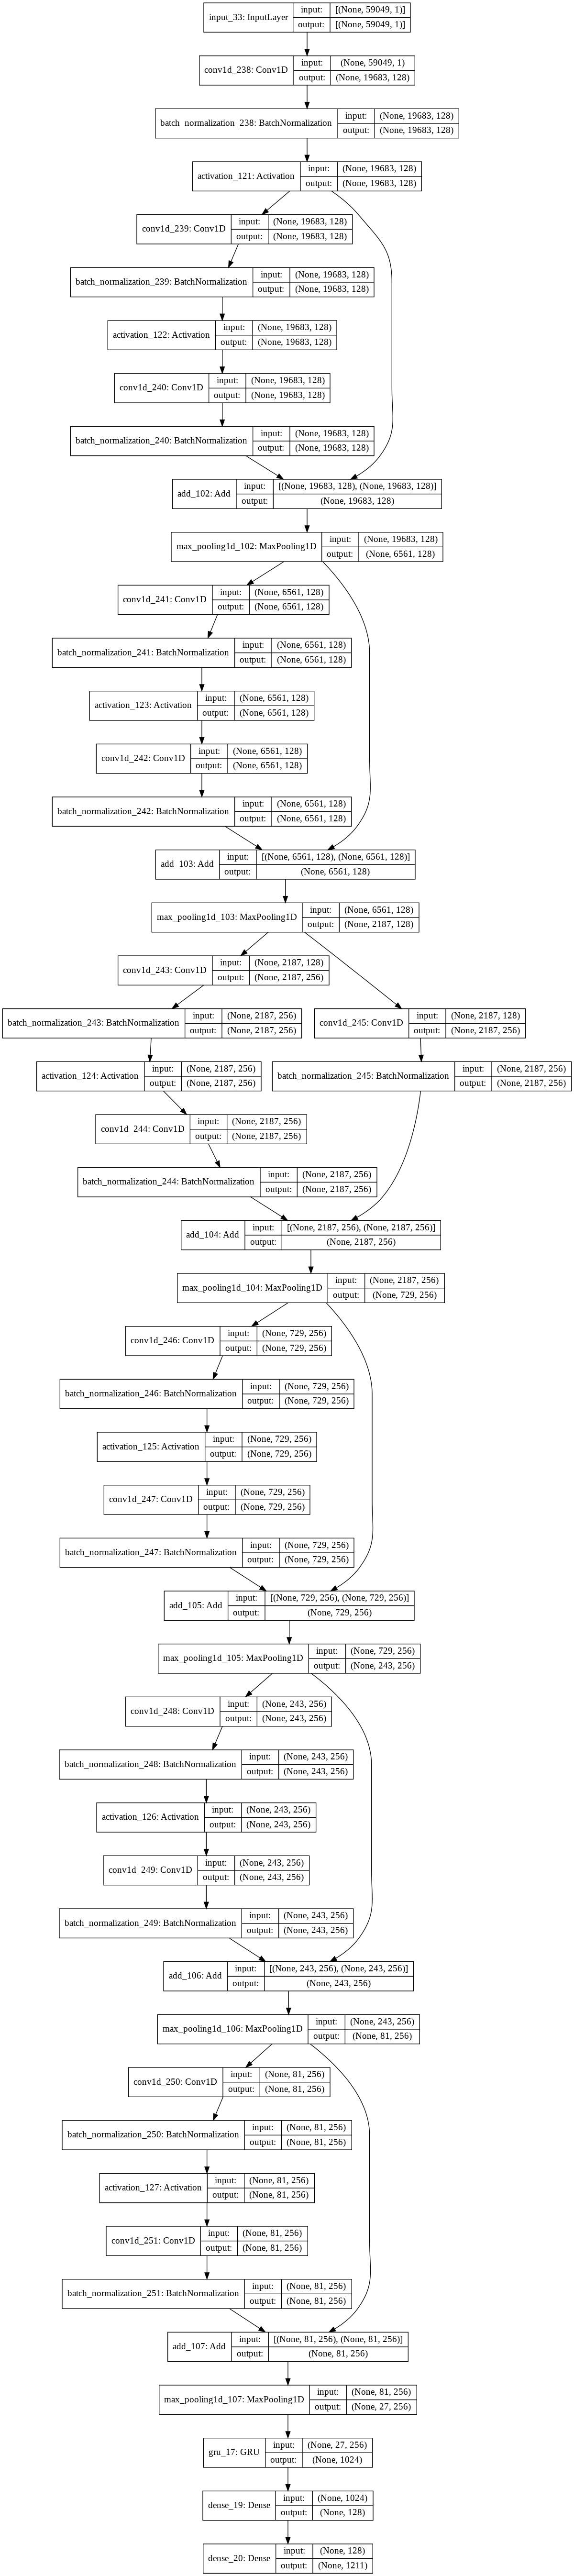

In [138]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [139]:
del tmp